In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Load the dataset
df = pd.read_csv("Cleaned_Sorted_SummerStudentAdmissions.csv")

# Display basic information
display(df.head())

# Check for missing values
df.dropna(inplace=True)

# Check available columns
print("Dataset Columns:", df.columns.tolist())

# Identify categorical columns dynamically
categorical_cols = ['State', 'Gender', 'ExperienceLevel']
print("Identified Categorical Columns:", categorical_cols)




,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel,TotalScore,ExperienceLevel
0,Admit,California,3.66,0.9,956.0,89,Female,1,1045.0,Low
1,Admit,California,3.69,3.2,967.0,93,Female,3,1060.0,Medium
2,Admit,California,3.70,1.2,969.0,94,Male,2,1063.0,Low
3,Admit,California,3.70,1.4,966.0,94,Male,0,1060.0,Low
4,Admit,California,3.70,2.7,799.0,97,Female,5,896.0,Medium


Dataset Columns: ['Decision', 'State', 'GPA', 'WorkExp', 'TestScore', 'WritingScore', 'Gender', 'VolunteerLevel', 'TotalScore', 'ExperienceLevel']
Identified Categorical Columns: ['State', 'Gender', 'ExperienceLevel']


In [10]:
# Convert categorical columns to numerical
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode the target variable 'Decision'
le_decision = LabelEncoder()
df['Decision'] = le_decision.fit_transform(df['Decision'])
num_classes = len(le_decision.classes_)

# Define features and target variable
X = df.drop(columns=['Decision'])
y = df['Decision']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binarize target for multiclass ROC handling AFTER train-test split
y_binarized_test = label_binarize(y_test, classes=range(num_classes))

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))




Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.67      0.67      0.67         3
           2       0.89      1.00      0.94         8

    accuracy                           0.89        18
   macro avg       0.85      0.84      0.84        18
weighted avg       0.90      0.89      0.89        18

Confusion Matrix:
 [[6 1 0]
 [0 2 1]
 [0 0 8]]


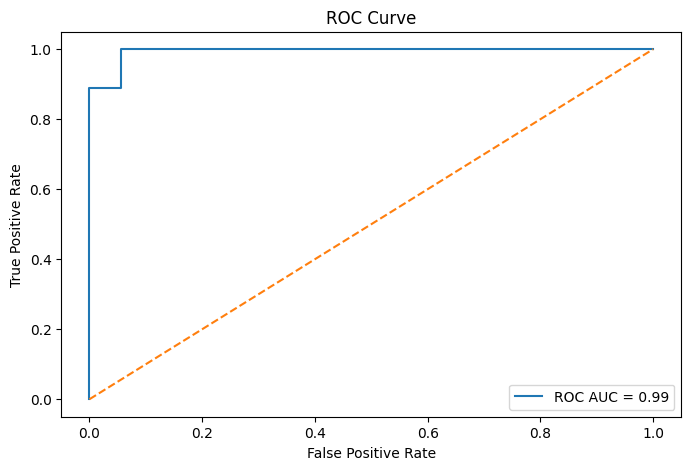

/var/folders/1g/cyz8p0_51_x80b7fxr3ywkn00000gn/T/ipykernel_76278/1074746077.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='coolwarm')


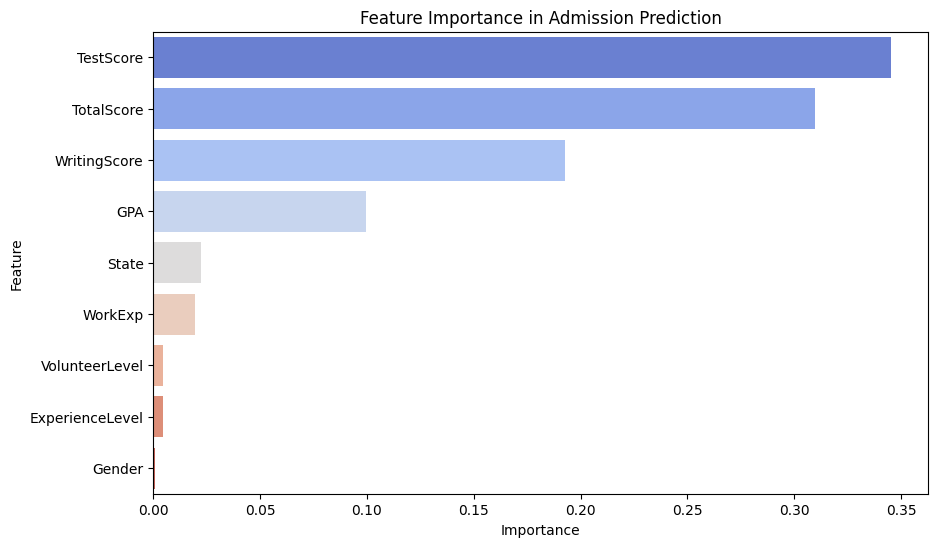

In [11]:
# Handle binary vs. multiclass ROC AUC
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    auc_score = roc_auc_score(y_test, y_proba[:, 1])
else:
    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
    fpr, tpr, _ = roc_curve(y_binarized_test.ravel(), y_proba.ravel())

# Plot ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance Visualization
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='coolwarm')
plt.title('Feature Importance in Admission Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
